In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
from keras.layers import Flatten
import cv2, os

from keras.layers import MaxPooling2D

In [2]:
!mkdir ~/.kaggle

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"damilola11199","key":"c02081ad2e83fc0f77dec11d86b9c7d2"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download shashankrapolu/human-action-recognition-dataset

100% 207M/208M [00:12<00:00, 21.0MB/s]
100% 208M/208M [00:12<00:00, 17.0MB/s]


In [5]:
!unzip /content/human-action-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Structured/train/hugging/Image_9980.jpg  
  inflating: Structured/train/hugging/Image_9999.jpg  
  inflating: Structured/train/laughing/Image_10000.jpg  
  inflating: Structured/train/laughing/Image_10001.jpg  
  inflating: Structured/train/laughing/Image_10028.jpg  
  inflating: Structured/train/laughing/Image_10036.jpg  
  inflating: Structured/train/laughing/Image_10037.jpg  
  inflating: Structured/train/laughing/Image_1004.jpg  
  inflating: Structured/train/laughing/Image_1005.jpg  
  inflating: Structured/train/laughing/Image_10074.jpg  
  inflating: Structured/train/laughing/Image_10093.jpg  
  inflating: Structured/train/laughing/Image_10095.jpg  
  inflating: Structured/train/laughing/Image_10114.jpg  
  inflating: Structured/train/laughing/Image_10149.jpg  
  inflating: Structured/train/laughing/Image_10196.jpg  
  inflating: Structured/train/laughing/Image_10225.jpg  
  inflating: Structured/train/laughing/Imag

In [6]:
train_directory = r'/content/Structured/train'
test_directory  = r'/content/Structured/train'


NUM_CLASSES = 15

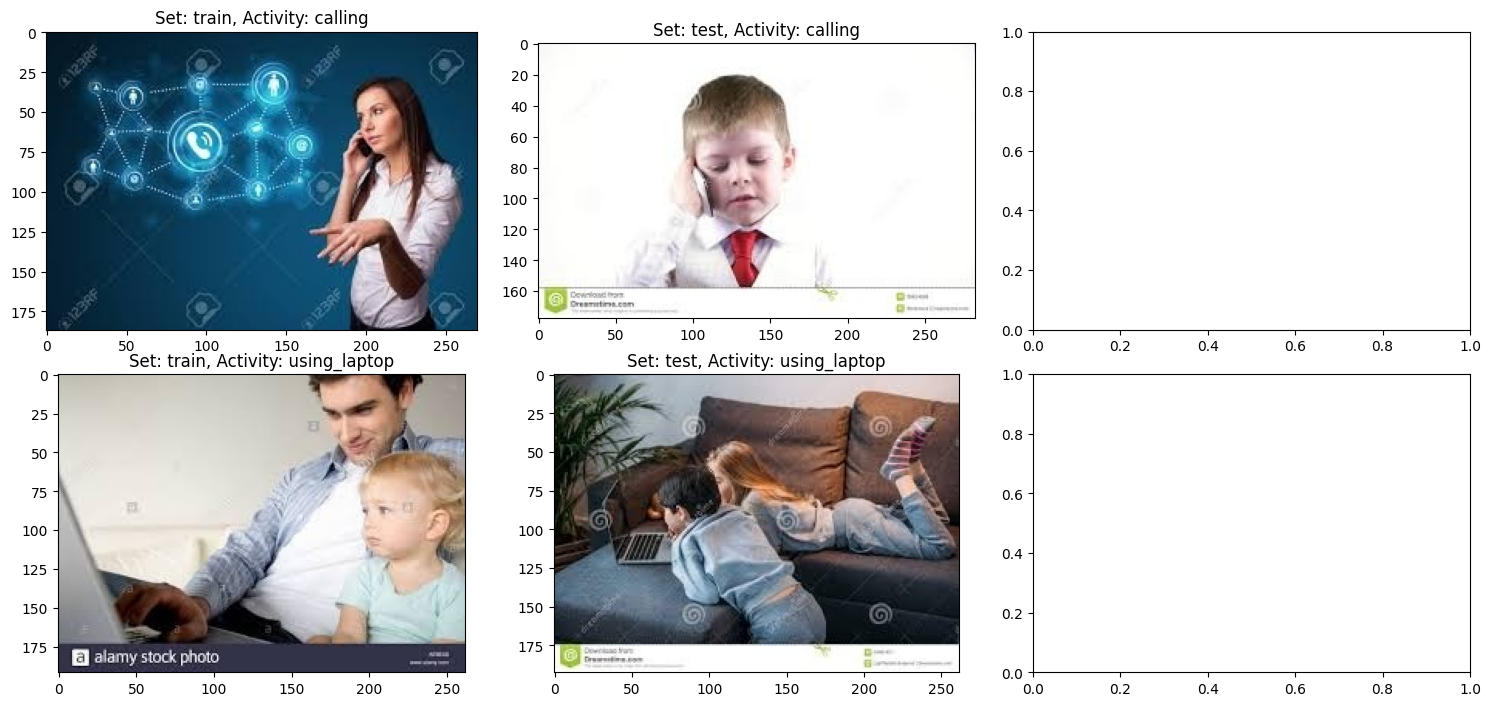

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
input_path = '/content/Structured/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/calling/'+os.listdir(set_path+'/calling')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Activity: calling'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/using_laptop/'+os.listdir(set_path+'/using_laptop')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Activity: using_laptop'.format(_set))

In [ ]:
#generating data
preprocess_function = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale= 1./255,
                                  horizontal_flip= True,
                                  width_shift_range= 0.05,
                                  height_shift_range= 0.1,
                                  rotation_range= 10,
                                  preprocessing_function= preprocess_function
                                  )

test_datagen = ImageDataGenerator(rescale= 1./255,
                                 preprocessing_function= preprocess_function)

train_generator = train_datagen.flow_from_directory(directory= train_directory,
                                                    target_size= (224, 224),
                                                    batch_size = 64,
                                                    shuffle = True,
                                                    color_mode = 'rgb',
                                                    subset = 'training',
                                                    class_mode = 'categorical',
                                                    seed = 2
                                                   )

test_generator = test_datagen.flow_from_directory(directory= test_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 shuffle= False,
                                                 color_mode= 'rgb',
                                                 class_mode = 'categorical',
                                                 seed = 2)


Found 10710 images belonging to 15 classes.
Found 10710 images belonging to 15 classes.


In [ ]:
our_model_base = tf.keras.applications.resnet.ResNet152(input_shape=(224,224,3), weights='imagenet',
                                                    include_top=False)

our_model_base.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

In [ ]:
#creating model pipeline
def last_model(inputs):
    x = our_model_base(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='classification')(x)

    return x

def model_compile():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    outputs  = last_model(inputs)
    model = tf.keras.Model(inputs= inputs, outputs= outputs)
    model.compile(optimizer= tf.keras.optimizers.SGD(0.001), loss='categorical_crossentropy',
                 metrics=['acc'])

    return model

In [ ]:
#compiling model
model = model_compile()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classification (Dense)      (None, 15)                30735     
                                                                 
Total params: 58,401,679
Trainable params: 58,250,255
Non-trainable params: 151,424
_________________________________________________________________


In [ ]:
#start training
training_checkpoint = tf.keras.callbacks.ModelCheckpoint('ResNet152_HAR-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
                                          save_best_only=True, monitor='val_acc', verbose=1)

#earlystopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss')

train_stats = model.fit(train_generator,
                        batch_size= 64,
                        validation_data= test_generator,
                        validation_batch_size= 64,
                        epochs= 17,
                        callbacks=[training_checkpoint]
                        )

Epoch 1/17
168/168 [==============================] - ETA: 0s - loss: 2.5066 - acc: 0.2152
Epoch 1: val_acc improved from -inf to 0.07404, saving model to ResNet152_HAR-001-0.215219-0.074043.h5
168/168 [==============================] - 441s 2s/step - loss: 2.5066 - acc: 0.2152 - val_loss: 2.9725 - val_acc: 0.0740
Epoch 2/17
168/168 [==============================] - ETA: 0s - loss: 1.8008 - acc: 0.4471
Epoch 2: val_acc improved from 0.07404 to 0.07955, saving model to ResNet152_HAR-002-0.447059-0.079552.h5
168/168 [==============================] - 360s 2s/step - loss: 1.8008 - acc: 0.4471 - val_loss: 3.0326 - val_acc: 0.0796
Epoch 3/17
168/168 [==============================] - ETA: 0s - loss: 1.4415 - acc: 0.5659
Epoch 3: val_acc improved from 0.07955 to 0.14304, saving model to ResNet152_HAR-003-0.565920-0.143044.h5
168/168 [==============================] - 360s 2s/step - loss: 1.4415 - acc: 0.5659 - val_loss: 2.7465 - val_acc: 0.1430
Epoch 4/17
168/168 [==========================

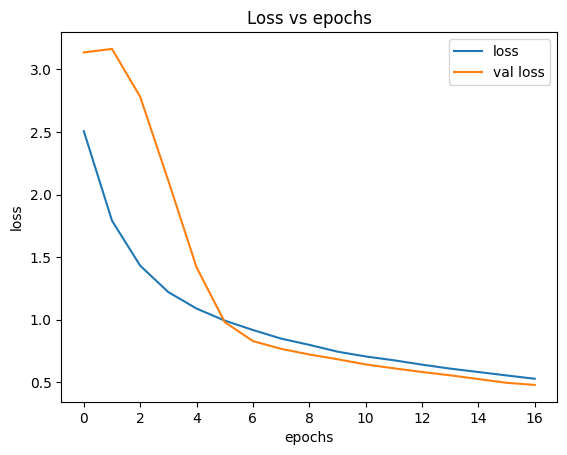

In [ ]:
epochs = [i for i in range(17)]
plt.plot(epochs, train_stats.history['loss'], label='loss')
plt.plot(epochs, train_stats.history['val_loss'], label='val loss')

plt.title('Loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

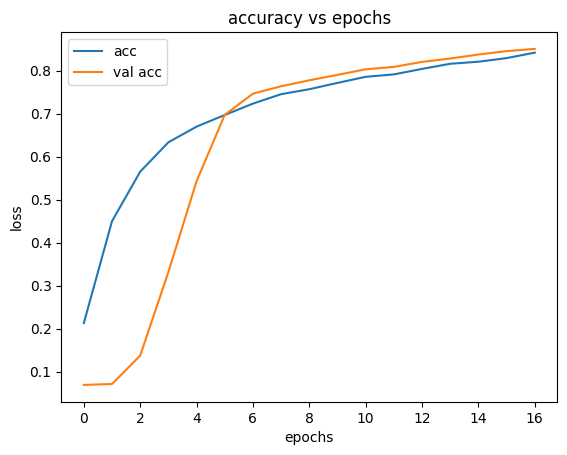

In [ ]:
epochs = [i for i in range(17)]
plt.plot(epochs, train_stats.history['acc'], label= 'acc')
plt.plot(epochs, train_stats.history['val_acc'], label= 'val acc')

plt.title('accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [ ]:
#saving trained model as json
model_json = model.to_json()
with open('ResNet152.json', 'w') as json_file:
    json_file.write(model_json)

print('Model saved')

Model saved


In [ ]:
#function to load test data
def create_test_generator(test_path):

    preprocess_function = tf.keras.applications.resnet.preprocess_input
    SEED = 12


    test_datagen = ImageDataGenerator(rescale= 1./255,
                                      preprocessing_function= preprocess_function
                                     )

    test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                       target_size = (224 ,224),
                                                        batch_size = 64,
                                                        shuffle  = False ,
                                                        color_mode = "rgb",
                                                        class_mode = "categorical",
                                                        seed = 12
                                                      )

    return test_generator

In [ ]:
def Load_Model(modelpath_json, weights_path):

    #loading the model
    json_file = open(modelpath_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")

    model = loaded_model
    clear_output()

    return model

def show_model_summary(model):

    model.summary()

In [ ]:
def make_predictions(model, test_generator):

    preds = model.predict(test_generator)
    y_preds = np.argmax(preds , axis = 1)
    y_test = np.array(test_generator.labels)

    return y_preds, y_test

def classificn_report(y_test, y_preds):

    output_details = classification_report(y_test, y_preds, output_dict=True)
    print(classification_report(y_test, y_preds))
    return output_details

def generate_cm_data(y_test, y_preds):
    NUM_CLASSES = 15
    CLASS_LABELS  = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
                    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
                    'texting', 'using_laptop']

    cm_data = confusion_matrix(y_test , y_preds)
    cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)

    all_mod_rows = []
    for i in range(NUM_CLASSES):
        row = cm.iloc[i]
        row_total = 0
        for k in range(NUM_CLASSES):
            row_total += row[k]
        mod_row = []
        for j in range(NUM_CLASSES):
            mod_row.append(round(row[j]/row_total, 2))
        all_mod_rows.append(np.array(mod_row))

    return pd.DataFrame(all_mod_rows, columns=CLASS_LABELS, index=CLASS_LABELS)


In [ ]:
def show_predictions(test_path, y_preds):

    CLASS_LABELS  = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
                    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
                    'texting', 'using_laptop']

    img_datagen = ImageDataGenerator(rescale = 1./255)
    img_generator = img_datagen.flow_from_directory(directory = test_path,
                                                       target_size = (224 ,224),
                                                        batch_size = 64,
                                                        shuffle  = False ,
                                                        color_mode = "rgb",
                                                        class_mode = "categorical",
                                                        seed = 12
                                                      )
    clear_output()

    images, classes = next(img_generator)

    pred_lbls = [CLASS_LABELS[idx] for idx in y_preds]
    display_multiple_images(images, pred_lbls)

def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_multiple_images(images, titles, title_colors=None):
    subplot = 991
    plt.figure(figsize=(15,15))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], subplot+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
#generating test data
test_path = r"/content/Structured/test"
test_generator = create_test_generator(test_path)

Found 1890 images belonging to 15 classes.


In [ ]:
#loading saved model along with weights
model_path = r'/content/drive/MyDrive/ResNet152.json'
weights_path = r'/content/drive/MyDrive/ResNet152_HAR-017-0.841923-0.850607.h5'
model = Load_Model(model_path, weights_path)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classification (Dense)      (None, 15)                30735     
                                                                 
Total params: 58,401,679
Trainable params: 58,250,255
Non-trainable params: 151,424
_________________________________________________________________


In [ ]:
#predictions
y_preds, y_test = make_predictions(model, test_generator)
print('Done')

30/30 [==============================] - 17s 496ms/step
Done


In [ ]:
#evaluating classification report
output_details = classificn_report(y_test, y_preds)

print('Accuracy', output_details['accuracy'])
# 0 --> calling
# 1 --> clapping
# 2 --> cycling
# 3 --> dancing
# 4 --> drinking
# 5 --> eating
# 6 --> fighting
# 7 --> hugging
# 8 --> laughing
# 9 --> listening_to_music
# 10 --> running
# 11 --> sitting
# 12 --> sleeping
# 13 --> texting
# 14 --> using_laptop

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       126
           1       0.88      0.67      0.76       126
           2       0.92      0.97      0.95       126
           3       0.80      0.75      0.78       126
           4       0.79      0.79      0.79       126
           5       0.86      0.93      0.89       126
           6       0.82      0.72      0.77       126
           7       0.74      0.72      0.73       126
           8       0.80      0.83      0.81       126
           9       0.55      0.75      0.63       126
          10       0.83      0.81      0.82       126
          11       0.53      0.55      0.54       126
          12       0.86      0.87      0.86       126
          13       0.76      0.64      0.70       126
          14       0.72      0.78      0.75       126

    accuracy                           0.77      1890
   macro avg       0.77      0.77      0.77      1890
weighted avg       0.77   

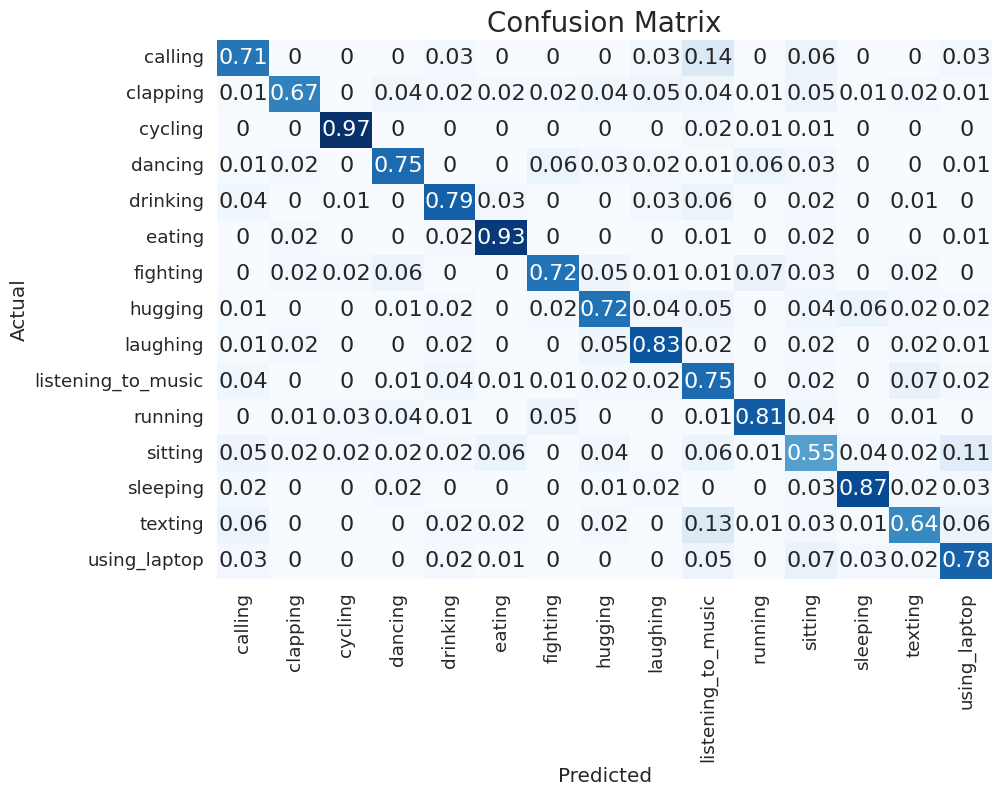

In [ ]:
#plotting confusion matrix (in terms of recall scores)
cm = generate_cm_data(y_test, y_preds)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


In [ ]:

def predict_image(model, image_path):
    CLASS_LABELS = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting',
                    'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping',
                    'texting', 'using_laptop']

    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_label = CLASS_LABELS[np.argmax(predictions)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(predicted_label, fontsize=16)
    plt.show()


1/1 [==============================] - 10s 10s/step


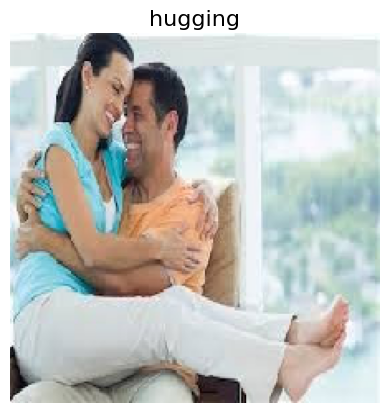

In [ ]:
model_path = '/content/drive/MyDrive/ResNet152.json'
weights_path = '/content/drive/MyDrive/ResNet152_HAR-017-0.841923-0.850607.h5'
loaded_model = Load_Model(model_path, weights_path)

image_path = '/content/drive/MyDrive/Image_10438.jpeg'
predict_image(loaded_model, image_path)
